In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
from scipy import stats as stats 
import statsmodels.api as sm

# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


### Open our SOS data

In [486]:
sos_30min = xr.open_dataset('../../01_data/processed_data/sos_ds_30M_storage.nc')
# calculate longwave radiation for SOS data
SIGMA = 5.67e-8
sos_30min = sos_30min.assign(R_lw_up = ((sos_30min.Rpile_out_9m_d + (sos_30min.Tcase_out_9m_d+273.15)**4*SIGMA)))
sos_30min = sos_30min.assign(R_lw_down = ((sos_30min.Rpile_in_9m_d + (sos_30min.Tcase_in_9m_d+273.15)**4*SIGMA)))

In [490]:
sos_30min_RH = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'RH' in var]]
sos_30min_T = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'T' in var]]
sos_30min_winds = sos_30min[[var for var in hf.WIND_VARIABLES if 'spd' in var or 'dir' in var]]
sos_30min_swe = sos_30min[['SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c']].to_array(dim='snow').mean('snow') # estimate of bulk density
sos_30min_snow_depth_est = (sos_30min_swe)/250 # convert from mm of depth to meters of snow by converting to meters and multiplying by 250 kg/m^3
# sublimation rate
sos_30min_ec_h2o = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__3m' in var]].to_array(dim='3m').mean('3m')
sos_30min_ec_temp = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_tc__3m' in var]].to_array(dim='3m').mean('3m')
# blowing snow flux
sos_30min_bsf = sos_30min[[var for var in hf.SNOW_FLUX]].to_array(dim='total').sum('total')
# radiation
sos_30min_rad = sos_30min[[var for var in hf.RADIAION_VARIABLES if 'R' in var]+['R_lw_up', 'R_lw_down']]
# calculate net radiation
sos_30min_rad['rnet'] = (sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d']) + (sos_30min_rad['R_lw_down'] - sos_30min_rad['R_lw_up'])

# calculate mixing ratio and air density
sos_30min_mixingratio = calc.mixing_ratio_from_relative_humidity((sos_30min['P_10m_c'].values)*units.units('hPa'), sos_30min['T_10m_c'], sos_30min['RH_10m_c'])
sos_30min_airdensity = calc.density((sos_30min['P_10m_c'].values)*units.units('hPa'), sos_30min['T_10m_c'], sos_30min_mixingratio)

In [366]:
# correct the RH values to make them with respect to ice
def saturation_vapor_pressure_wrt_ice(T, method='Huang'):
    # from Huang et al. 2018
    if method == 'Huang':
        Ps = np.exp(43.494 - (6545.8 / (T + 278.0)))/((T + 868)**2)
    elif method == 'Magnus':
        # From (Alduchov and Eskridge 1996).
        Ps = 611.21 * np.exp((22.587*T)/(T + 273.86))
    return Ps
def saturation_vapor_pressure_wrt_water(T, method='Huang'):
    if method == 'Huang':
        # from Huang et al. 2018
        Ps = np.exp(34.494 - (4924.99 / (T + 237.1)))/((T+105)**1.57)
    if method == 'Magnus':
    # From (Alduchov and Eskridge 1996).
        Ps = 610.94 * np.exp((17.625*T)/(T + 243.04))
    return Ps

cold_temp_array = np.arange(-20, 0, 1)
warm_temp_array = np.arange(-20, 0, 1)
sat_vap_pres_ice_huang = saturation_vapor_pressure_wrt_ice(cold_temp_array)
sat_vap_pres_ice_magnus= saturation_vapor_pressure_wrt_ice(cold_temp_array, method='Magnus')
sat_vap_pres_water_huang = saturation_vapor_pressure_wrt_water(warm_temp_array)
sat_vap_pres_water_magnus = saturation_vapor_pressure_wrt_water(warm_temp_array, method='Magnus')

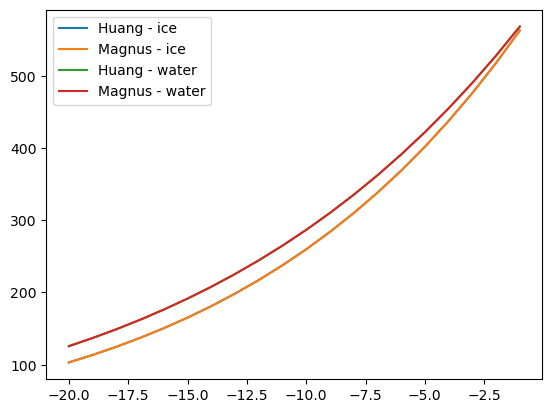

In [367]:
# Testing to compare
plt.plot(cold_temp_array, sat_vap_pres_ice_huang, label='Huang - ice')
plt.plot(cold_temp_array, sat_vap_pres_ice_magnus, label='Magnus - ice')
plt.plot(warm_temp_array, sat_vap_pres_water_huang, label='Huang - water')
plt.plot(warm_temp_array, sat_vap_pres_water_magnus, label='Magnus - water')
plt.legend()

In [368]:
sos_30min_RH_ice = sos_30min_RH.copy()
# covert to RH with respect to ice by multiplying with the ratio of the saturation vapor pressure of water and ice
for var in sos_30min_RH_ice:
    if 'RH' in var:
        T_var = var.replace('RH', 'T')
        # create a mask where T is below 0
        mask = sos_30min_T[T_var] > 0
        # use the mask to calculate RH with respect to ice
        sos_30min_RH_ice[var] = sos_30min_RH_ice[var].where(mask, sos_30min_RH_ice[var] * saturation_vapor_pressure_wrt_water(sos_30min_T[T_var].values)/saturation_vapor_pressure_wrt_ice(sos_30min_T[T_var].values))

In [498]:
long_events = [['2022-12-06 18:00:00', '2022-12-07 06:00:00'],
                ['2022-12-12 12:00:00', '2022-12-14 21:00:00'],
                ['2022-12-21 12:00:00', '2022-12-23 09:00:00'],
                ['2023-02-05 18:00:00', '2023-02-06 06:00:00'],
                ['2023-02-08 15:00:00', '2023-02-10 00:00:00'],
                ['2023-02-19 06:00:00', '2023-02-20 03:00:00'],
                ['2023-02-21 15:00:00', '2023-02-22 03:00:00'],
                ['2023-02-22 18:00:00', '2023-02-23 06:00:00'],
                ['2023-02-26 15:00:00', '2023-02-27 06:00:00'],
                ['2023-03-03 18:00:00', '2023-03-04 09:00:00'],
                ['2023-03-05 00:00:00', '2023-03-08 00:00:00'],
                ['2023-03-09 09:00:00', '2023-03-10 00:00:00']]

In [590]:
# now lets select a large sublimation event to visualize
start, end = long_events[-5]
# get data for plots
sos_30min_RH_ice_sel = sos_30min_RH_ice.sel(time=slice(start, end))
sos_30min_T_sel = sos_30min_T.sel(time=slice(start, end))
sos_30min_winds_sel = sos_30min_winds.sel(time=slice(start, end))
sos_30min_snow_depth_sel = sos_30min_snow_depth_est.sel(time=slice(start, end))
sos_30min_bsf_sel = sos_30min_bsf.sel(time=slice(start, end))

# net radiation
sos_30min_rnet_sel = sos_30min_rad.sel(time=slice(start, end))['rnet']
### Calculate turbulent heat fluxes
# Constant values
rho_w = 1000 * units.units('kg/m^3') # density of water kg/m^3
g2kg = (1/1000 * units.units('kg/g')) # convert from g to kg
mm_per_meter = 1000 * units.units('mm/m') # convert from m to mm
s_in_hour = 3600 * units.units('seconds/hour') # seconds in an hour
latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
# heat_capacity_air units J/kg/C
heat_capacity_air = (1005)*units.units('J/kg/C') # J/kg/C

sos_30min_sublimation_sel = (sos_30min_ec_h2o.sel(time=slice(start, end))*units.units('g/m^3 * m/s')) * 1/rho_w * g2kg * mm_per_meter * s_in_hour # convert from g/m^2/s to mm/hr
sos_30min_latent_heat_sel = sos_30min_sublimation_sel * latent_heat_sublimation / mm_per_meter * rho_w / s_in_hour # convert to W/m^2
sos_30min_sensible_heat_sel = heat_capacity_air*(sos_30min_ec_temp*units.units('deg * m/s')*sos_30min_airdensity).sel(time=slice(start, end)) # convert to W/m^2 from degC * m/s

In [591]:
# prepare data for wind barbs
def create_wind_barbs(wind_data, level):
    spd = wind_data[[var for var in hf.WIND_VARIABLES if f'spd_{level}m' in var]].to_pandas()
    dir = wind_data[[var for var in hf.WIND_VARIABLES if f'dir_{level}m' in var]].to_pandas()
    md = 270 - dir.values
    md[md < 0] += 360
    u = (spd * np.cos(np.deg2rad(md))).mean(axis=1).values
    v = (spd * np.sin(np.deg2rad(md))).mean(axis=1).values
    time = wind_data.time.values
    level = np.ones_like(u) * level
    return u,v,time,level

In [592]:
# Define the colors: brown, white, and pink
colors = ['goldenrod', 'white', 'magenta']

# Create the colormap
cmap = LinearSegmentedColormap.from_list('brown_white_pink', colors)

(2.0, 11.0)

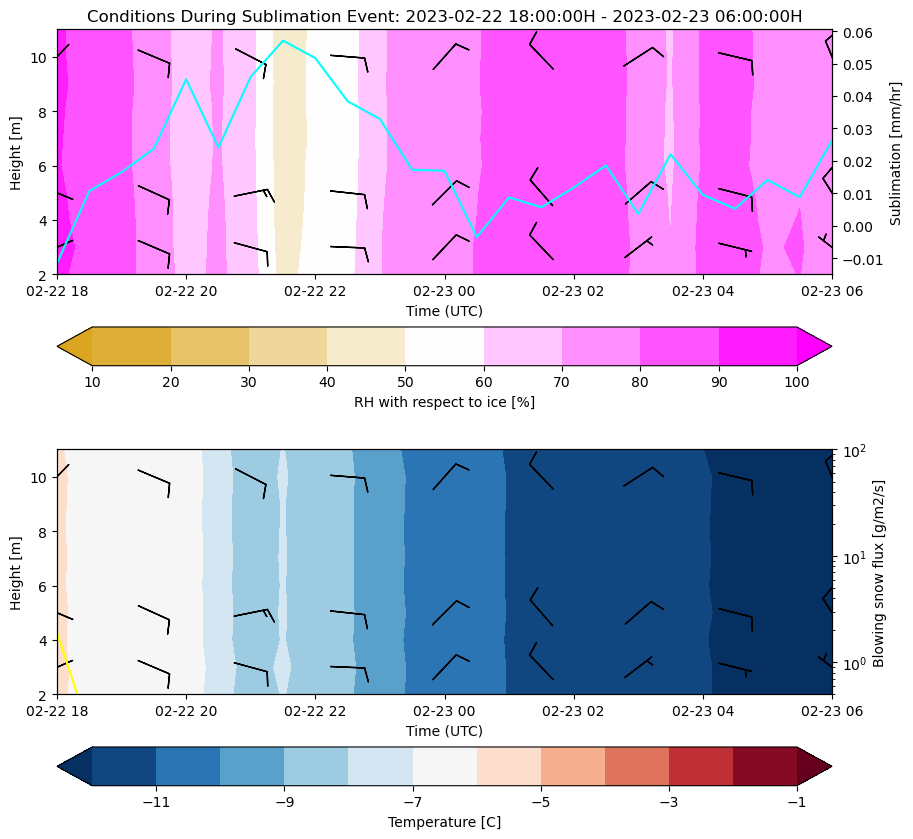

In [593]:
# now try this with matplotlib
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,10))
x = sos_30min_RH_ice_sel.time.values
y = np.arange(2,12,1)
z_rh = sos_30min_RH_ice_sel.to_pandas().T.iloc[0:10]
z_t = sos_30min_T_sel.to_pandas().T.iloc[0:10]
# linear interpolate missing values
z_rh = z_rh.interpolate(method='linear', limit=2)
# z_t = z_t.interpolate(method='linear')

# Plot the contours of RH
ax = axs[0]
# ax.contour(x, y, z_rh, colors='k', levels=np.arange(40,101,10))
c_rh = ax.contourf(x, y, z_rh, cmap=cmap, levels=np.arange(10,101,10), extend='both')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='cyan', linestyle='-', label='Sublimation @ 3m [mm/hr]')
ax2.set_ylabel('Sublimation [mm/hr]')
# add wind barbs at 10m every 9 measurements
barb_increments = dict(half=2.5, full=5, flag=26)
interval = 3
barb_data = [[create_wind_barbs(sos_30min_winds_sel, 3)],
             [create_wind_barbs(sos_30min_winds_sel, 5)],
             [create_wind_barbs(sos_30min_winds_sel, 10)]]
            #  [create_wind_barbs(sos_30min_winds_sel, 15)],
            #  [create_wind_barbs(sos_30min_winds_sel, 20)]]
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')

fig.colorbar(c_rh, ax=ax, label='RH with respect to ice [%]', orientation='horizontal')
ax.set_title(f'Conditions During Sublimation Event: {start}H - {end}H')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(2,11)


# Second plot contours of temperature
ax= axs[1]

c_t = ax.contourf(x, y, z_t, cmap='RdBu_r', levels=np.arange(-12,0,1), extend='both')
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')
ax2 = ax.twinx()
# also think of adding the sublimation rate
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='yellow', linestyle='-', label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux [g/m2/s]')
if sos_30min_bsf_sel.max() < 1:
    ax2.set_ylim(0,1)
else:
    ax2.set_yscale('log')
    ax2.set_ylim(0.5, 100)
# create third y-axis for blowing snow flux
fig.colorbar(c_t, ax=ax, label='Temperature [C]', orientation='horizontal')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(2,11)


In [594]:
# now we will plot the net radiation and sensible/latent heat fluxes for these periods
# Create the subplots layout
fig = make_subplots(
    rows=2, cols=3,
    row_heights=[0.6, 0.5],  # The first row (top) is 60% of the height
    column_widths=[0.33, 0.33, 0.33],  # The two subplots in the bottom row are equal width
    specs=[[{"colspan": 3}, None, None],  # First subplot spans both columns
           [{}, {}, {}]]  # Second and third subplots occupy the second row
)
fig.add_trace(go.Scatter(x=sos_30min_rnet_sel.time.values, y=sos_30min_rnet_sel.values, mode='lines', name='Net Radiation [W/m2]'))
fig.add_trace(go.Scatter(x=sos_30min_latent_heat_sel.time.values, y=sos_30min_latent_heat_sel.values, mode='lines', name='Latent Heat Flux [W/m2]'))
fig.add_trace(go.Scatter(x=sos_30min_sensible_heat_sel.time.values, y=sos_30min_sensible_heat_sel.values, mode='lines', name='Sensible Heat Flux [W/m2]'))

# and lower left,
fig.add_trace(go.Scatter(x=sos_30min_latent_heat_sel.values, y=sos_30min_sensible_heat_sel.values, mode='markers', showlegend=False), row=2, col=1)
# add 1-1 line
fig.add_trace(go.Scatter(x=[-100, 100], y=[100, -100], mode='lines', showlegend=False), row=2, col=1)
# and lower center
fig.add_trace(go.Scatter(x=sos_30min_latent_heat_sel.values, y=sos_30min_rnet_sel.values, mode='markers', showlegend=False), row=2, col=2)
fig.add_trace(go.Scatter(x=[-100, 100], y=[-100, 100], mode='lines', showlegend=False), row=2, col=2)

# and lower right
fig.add_trace(go.Scatter(x=sos_30min_sensible_heat_sel.values, y=sos_30min_rnet_sel.values, mode='markers', showlegend=False), row=2, col=3)
fig.add_trace(go.Scatter(x=[-100, 100], y=[-100, 100], mode='lines', showlegend=False), row=2, col=3)

fig.update_layout(xaxis_title='Time (UTC)', yaxis_title='Energy Flux [W/m2]', width=1000, height=800)
fig.update_yaxes(title_text='Sensible Heat Flux [W/m2]', row=2, col=1)
fig.update_xaxes(title_text='Latent Heat Flux [W/m2]', row=2, col=1)
fig.update_yaxes(title_text='Net Radiation [W/m2]', row=2, col=2)
fig.update_xaxes(title_text='Latent Heat Flux [W/m2]', row=2, col=2)
fig.update_yaxes(title_text='Net Radiation [W/m2]', row=2, col=3)
fig.update_xaxes(title_text='Sensible Heat Flux [W/m2]', row=2, col=3)
# create a tight layout
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))
# move y axis labels to the right for all
fig.update_yaxes(title_standoff=0)
# move the legend to the top center
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="center",
    x=0.5
))

